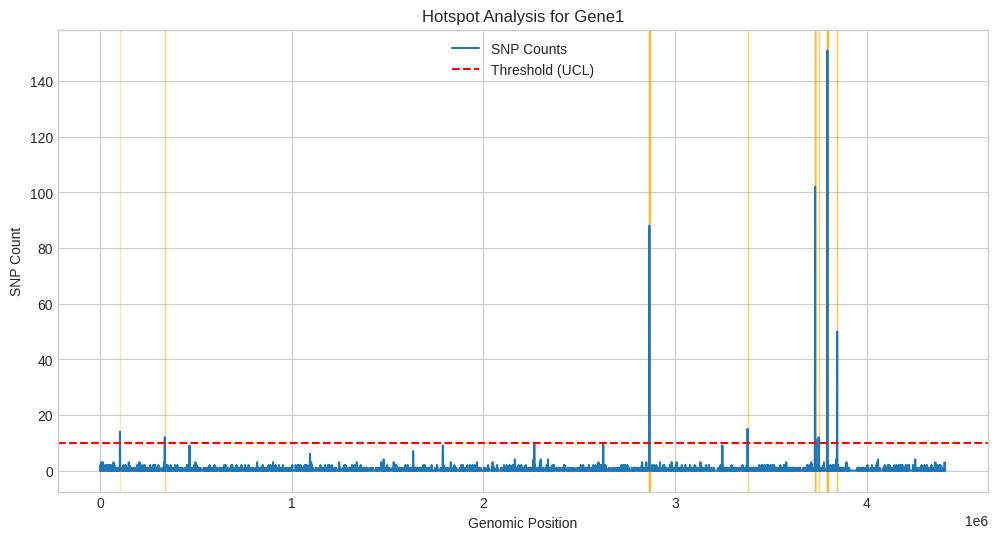

High-density hotspots:
      start      end  snp_count  \
18  3795500  3796500        151   

                                             features  
18  region,mobile_genetic_element,sequence_feature...  
Hotspots overlapping resistance genes:
Empty DataFrame
Columns: [start, end, snp_count, features, is_resistance]
Index: []
      start      end  snp_count gene_name
18  3795500  3796500        151   Rv3382c


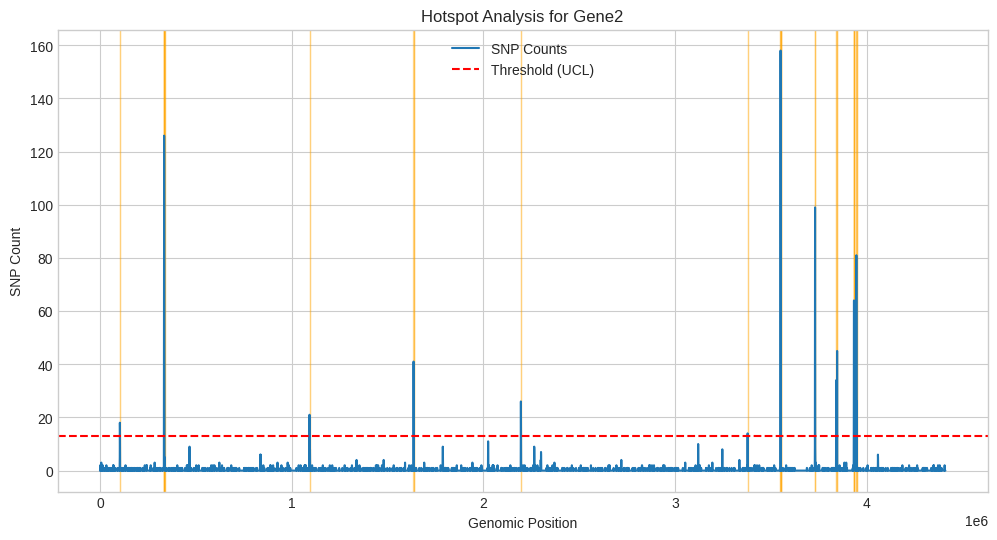

High-density hotspots:
      start      end  snp_count  \
4    335000   336000        126   
19  3551500  3552500        158   

                                          features  
4                                  region,gene,CDS  
19  region,mobile_genetic_element,sequence_feature  
Hotspots overlapping resistance genes:
Empty DataFrame
Columns: [start, end, snp_count, features, is_resistance]
Index: []
      start      end  snp_count gene_name
4    335000   336000        126   Rv0278c
19  3551500  3552500        158          


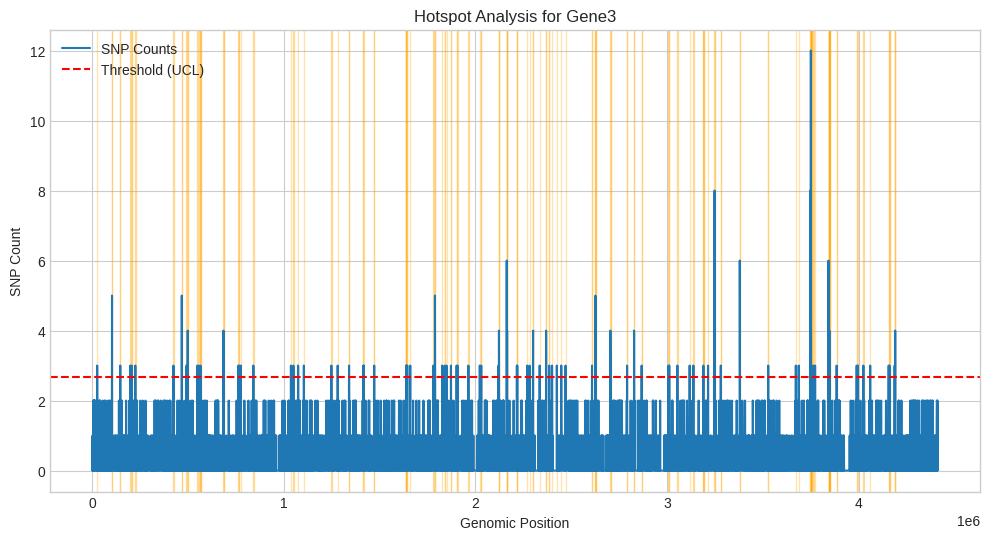

High-density hotspots:
       start      end  snp_count         features
103  3247000  3248000          7  region,gene,CDS
104  3247500  3248500          8  region,gene,CDS
113  3746000  3747000          8  region,gene,CDS
114  3746500  3747500          7  region,gene,CDS
115  3749500  3750500          9  region,gene,CDS
116  3750000  3751000         12  region,gene,CDS
Hotspots overlapping resistance genes:
Empty DataFrame
Columns: [start, end, snp_count, features, is_resistance]
Index: []
       start      end  snp_count gene_name
103  3247000  3248000          7      ppsA
104  3247500  3248500          8      ppsA
113  3746000  3747000          8     PPE55
114  3746500  3747500          7     PPE55
115  3749500  3750500          9     PPE55
116  3750000  3751000         12     PPE55


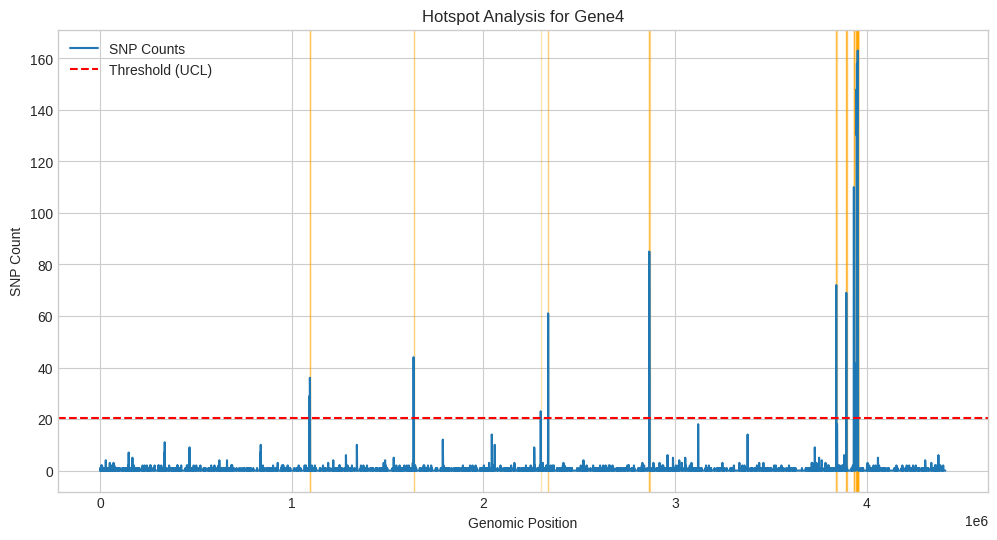

High-density hotspots:
Empty DataFrame
Columns: [start, end, snp_count, features]
Index: []
Hotspots overlapping resistance genes:
Empty DataFrame
Columns: [start, end, snp_count, features, is_resistance]
Index: []
Empty DataFrame
Columns: [start, end, snp_count, gene_name]
Index: []


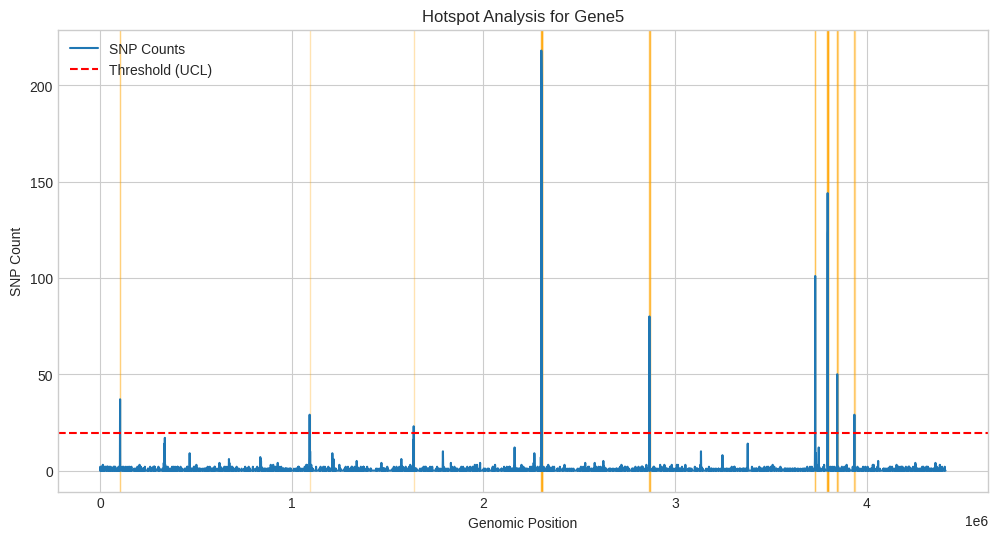

High-density hotspots:
     start      end  snp_count         features
5  2302500  2303500        218  region,gene,CDS
Hotspots overlapping resistance genes:
Empty DataFrame
Columns: [start, end, snp_count, features, is_resistance]
Index: []
     start      end  snp_count gene_name
5  2302500  2303500        218     pks12


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Helper Functions
def load_data(fasta_file):
    """Load reference genome from a FASTA file."""
    with open(fasta_file, 'r') as f:
        genome = ''.join(line.strip() for line in f if not line.startswith('>'))
    return genome

def parse_vcf(vcf_file):
    """Parse SNP positions from a VCF file."""
    # Read the file and skip metadata lines
    with open(vcf_file, 'r') as file:
        lines = [line.strip() for line in file if not line.startswith('##')]

    # Extract the header and data
    header = lines[0].split('\t')  # First line starting with "#"
    data_lines = lines[1:]         # Remaining lines contain SNP data

    # Load SNP data into a DataFrame
    snp_data = pd.DataFrame(
        [line.split('\t') for line in data_lines],
        columns=header
    )

    # Convert the 'POS' column to integers
    snp_data['POS'] = snp_data['POS'].astype(int)

    # Return the positions as a list
    return snp_data[['POS']].rename(columns={'POS': 'position'})




def sliding_window_snp_count(genome, snp_positions, window_size=1000, overlap=500):
    """Count SNPs in sliding windows."""
    windows = []
    snp_counts = []
    step = window_size - overlap
    for start in range(0, len(genome), step):
        end = start + window_size
        windows.append((start, end))
        count = sum(start <= pos < end for pos in snp_positions)
        snp_counts.append(count)
    return windows, snp_counts

def find_hotspots(snp_counts, threshold_factor=3):
    """Detect hotspots based on statistical thresholds."""
    mean = np.mean(snp_counts)
    std_dev = np.std(snp_counts)
    ucl = mean + threshold_factor * std_dev
    hotspots = [i for i, count in enumerate(snp_counts) if count > ucl]
    return hotspots, ucl

def extract_kmer_context(genome, snp_positions, k=7):
    """Extract k-mer context around each SNP."""
    kmers = []
    half_k = k // 2
    for pos in snp_positions:
        start = max(0, pos - half_k - 1)
        end = min(len(genome), pos + half_k)
        kmer = genome[start:end]
        if len(kmer) == k:
            kmers.append(kmer)
    return kmers

def annotate_hotspots(windows, hotspots, snp_counts):
    """Create a dataframe for hotspots with SNP count and window information."""
    data = []
    for i in hotspots:
        start, end = windows[i]
        data.append({'start': start, 'end': end, 'snp_count': snp_counts[i]})
    return pd.DataFrame(data)

def plot_hotspots(windows, snp_counts, hotspots, ucl, gene_name):
    """Plot SNP counts and highlight hotspots."""
    x = [start for start, end in windows]
    plt.figure(figsize=(12, 6))
    plt.plot(x, snp_counts, label='SNP Counts')
    plt.axhline(y=ucl, color='red', linestyle='--', label='Threshold (UCL)')
    for i in hotspots:
        plt.axvspan(windows[i][0], windows[i][1], color='orange', alpha=0.3)
    plt.xlabel('Genomic Position')
    plt.ylabel('SNP Count')
    plt.title(f'Hotspot Analysis for {gene_name}')
    plt.legend()
    plt.savefig(f'{gene_name}_hotspots.png')
    plt.show()

def annotate_with_genomic_features(hotspot_df, annotation_file):
    """Annotate hotspots with overlapping genomic features."""
    # Load the GFF file
    gff_data = pd.read_csv(
        annotation_file,
        sep='\t',
        header=None,
        comment='#',
        names=['seqid', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    )
    
    # Extract relevant columns
    annotations = gff_data[['start', 'end', 'feature']]

    # Annotate each hotspot
    hotspot_df['features'] = ''
    for i, row in hotspot_df.iterrows():
        overlapping_features = annotations[
            (annotations['start'] <= row['end']) & (annotations['end'] >= row['start'])
        ]['feature'].tolist()
        hotspot_df.at[i, 'features'] = ','.join(overlapping_features) if overlapping_features else 'None'

    return hotspot_df

# Filter the GFF annotation for overlapping regions
def map_gene_names(hotspot_df, gff_file):
    # Load GFF file
    gff_data = pd.read_csv(
        gff_file, sep='\t', header=None, comment='#',
        names=['seqid', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    )
    # Filter for gene entries
    gff_genes = gff_data[gff_data['feature'] == 'gene']

    # Annotate hotspots with gene names
    hotspot_df = hotspot_df.copy()  # Ensure we are working with a copy
    hotspot_df['gene_name'] = ''

    for i, row in hotspot_df.iterrows():
        overlapping_genes = gff_genes[
            (gff_genes['start'] <= row['end']) & (gff_genes['end'] >= row['start'])
        ]['attributes']
        # Extract the gene name from the attributes column
        hotspot_df.at[i, 'gene_name'] = ', '.join(
            overlapping_genes.str.extract(r'Name=([^;]+)')[0].dropna().unique()
        )

    return hotspot_df


# Main Function
def main():
    # Input files for the reference gene and comparison genes
    reference_file = '/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta'
    vcf_files = [
        '/kaggle/input/dataset/TB_TB/TB_TB/results/R1207.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/F11.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/EAI5.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/CDC1551.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/Beijing.filtered.vcf'
    ]
    gene_names = ['Gene1', 'Gene2', 'Gene3', 'Gene4', 'Gene5']
    annotation_file = '/kaggle/input/dataset/TB_TB/TB_TB/gfff/ncbi_dataset/data/GCF_000195955.2/genomic.gff'

    # Load reference genome
    reference_genome = load_data(reference_file)

    # Process each gene
    for i, vcf_file in enumerate(vcf_files):
        gene_name = gene_names[i]

        # Parse SNPs from VCF file
        snp_data = parse_vcf(vcf_file)
        snp_positions = snp_data['position'].tolist()

        # Sliding window SNP count
        windows, snp_counts = sliding_window_snp_count(reference_genome, snp_positions, window_size=1000, overlap=500)

        # Find hotspots
        hotspots, ucl = find_hotspots(snp_counts, threshold_factor=3)

        # Extract k-mer context
        kmers = extract_kmer_context(reference_genome, snp_positions, k=7)

        # Annotate hotspots
        hotspot_df = annotate_hotspots(windows, hotspots, snp_counts)
        hotspot_df = annotate_with_genomic_features(hotspot_df, annotation_file)
        hotspot_df.to_csv(f'{gene_name}_hotspots.csv', index=False)

        # Plot hotspots
        plot_hotspots(windows, snp_counts, hotspots, ucl, gene_name)
        # Analyze high-density regions
        threshold = hotspot_df['snp_count'].mean() + 2 * hotspot_df['snp_count'].std()
        high_density_hotspots = hotspot_df[hotspot_df['snp_count'] > threshold]

        print("High-density hotspots:")
        print(high_density_hotspots)
        # Check for known drug resistance genes in hotspots
        resistance_genes = ['katG', 'rpoB', 'inhA', 'embB', 'gyrA', 'pncA']
        hotspot_df['is_resistance'] = hotspot_df['features'].apply(
        lambda x: any(gene in x for gene in resistance_genes)
        )

        print("Hotspots overlapping resistance genes:")
        print(hotspot_df[hotspot_df['is_resistance']])
        

        # Apply the mapping function
        hotspot_df = map_gene_names(high_density_hotspots, '/kaggle/input/dataset/TB_TB/TB_TB/gfff/ncbi_dataset/data/GCF_000195955.2/genomic.gff')
        print(hotspot_df[['start', 'end', 'snp_count', 'gene_name']])



if __name__ == '__main__':
    main()


Saved local hotspots to /kaggle/working/R1207.filtered.vcf_local_hotspots.csv


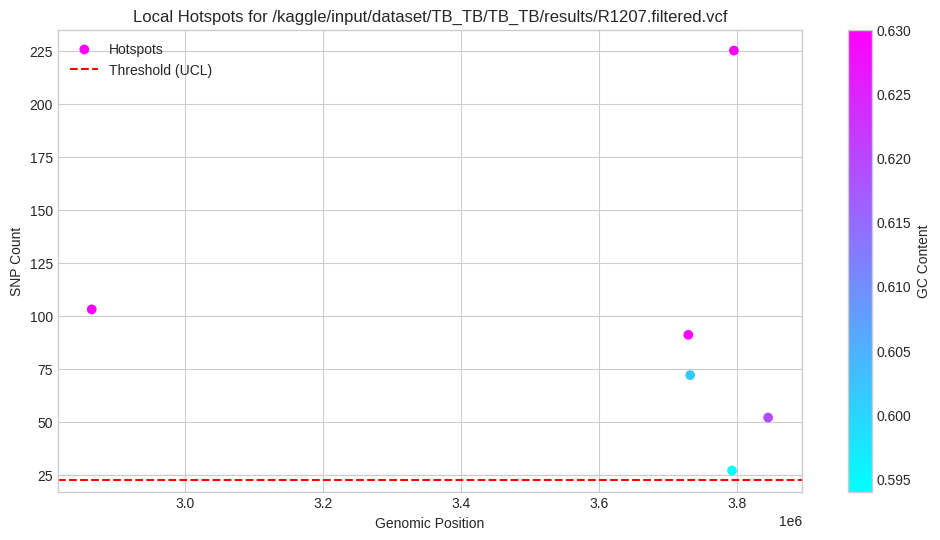

Saved local hotspots to /kaggle/working/F11.filtered.vcf_local_hotspots.csv


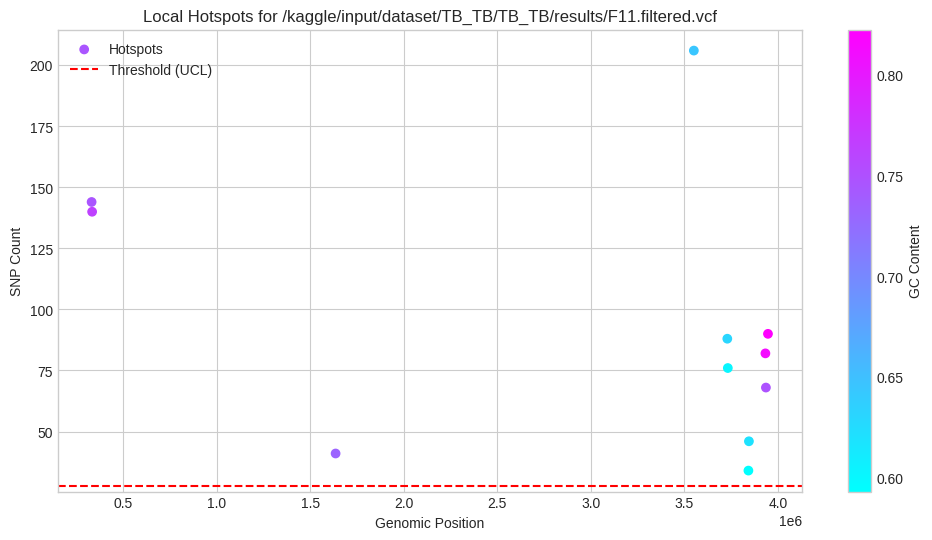

Saved local hotspots to /kaggle/working/EAI5.filtered.vcf_local_hotspots.csv


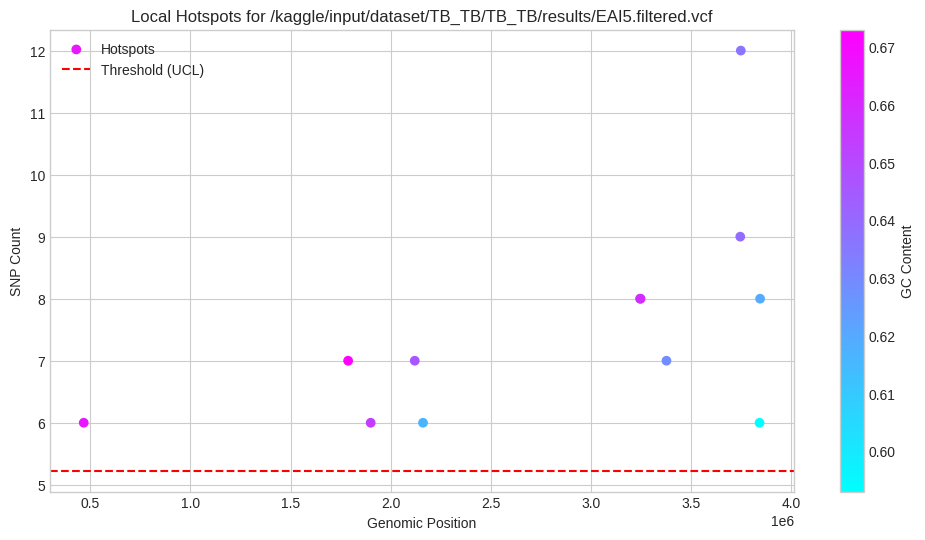

Saved local hotspots to /kaggle/working/CDC1551.filtered.vcf_local_hotspots.csv


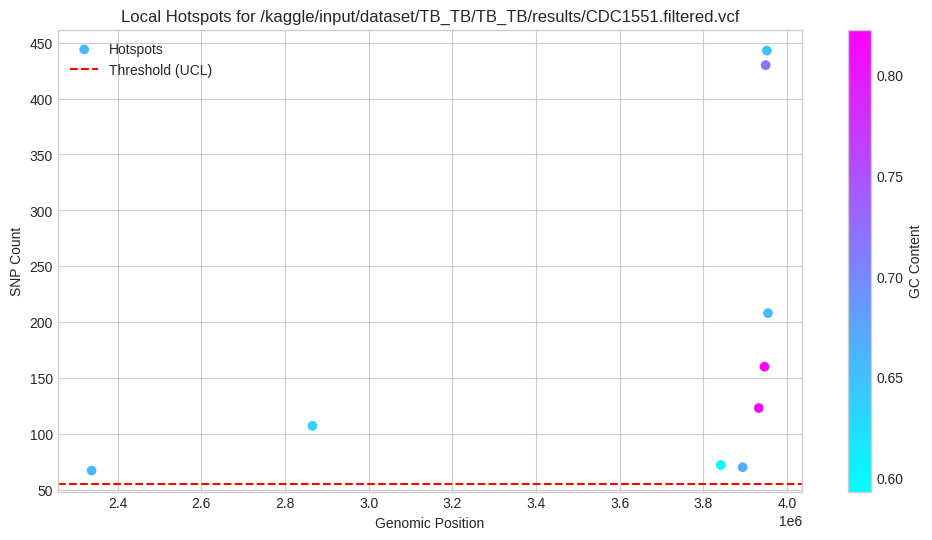

Saved local hotspots to /kaggle/working/Beijing.filtered.vcf_local_hotspots.csv


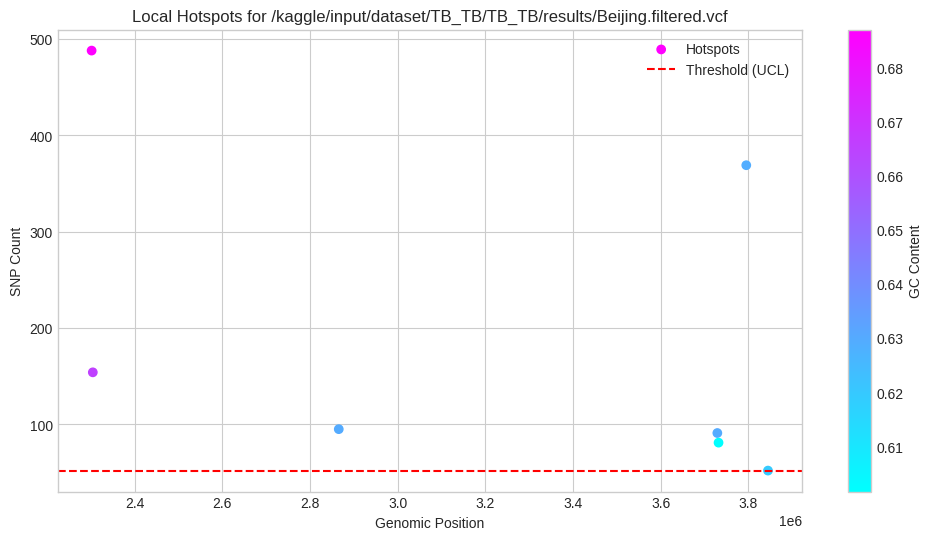

Saved global hotspots to /kaggle/working/global_hotspots.csv


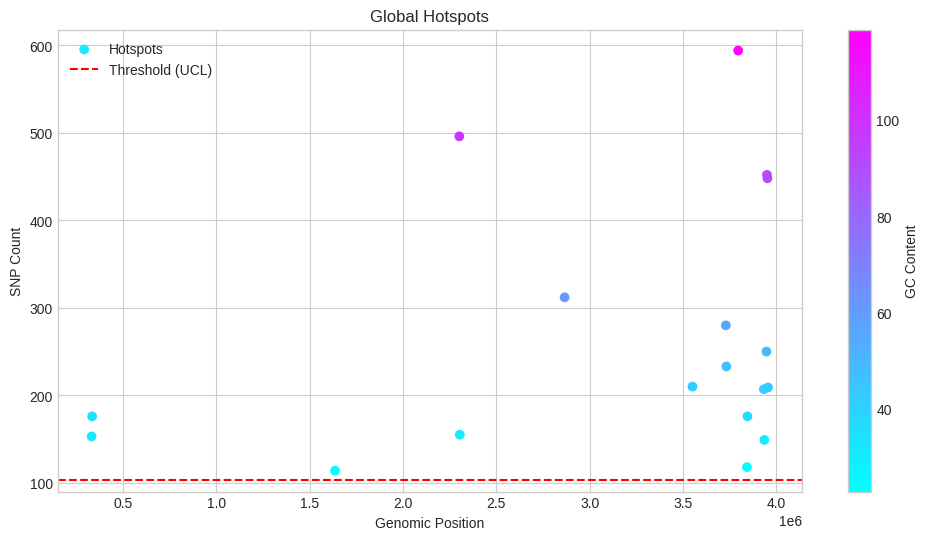

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

# Helper Functions
def load_data(fasta_file):
    """Load reference genome from a FASTA file."""
    with open(fasta_file, 'r') as f:
        genome = ''.join(line.strip() for line in f if not line.startswith('>'))
    return genome

def parse_vcf(vcf_file):
    """Parse SNP positions from a VCF file."""
    with open(vcf_file, 'r') as file:
        lines = [line.strip() for line in file if not line.startswith('##')]
        header = lines[0].split('\t')
        data_lines = lines[1:]
        snp_data = pd.DataFrame([line.split('\t') for line in data_lines], columns=header)
        snp_data['POS'] = snp_data['POS'].astype(int)
        return snp_data[['POS']].rename(columns={'POS': 'position'})

def sliding_window_analysis(genome, snp_positions, window_size=3000, overlap=250):
    """Calculate SNP density and GC content in sliding windows."""
    windows, snp_counts, gc_contents = [], [], []
    step = window_size - overlap

    for start in range(0, len(genome), step):
        end = start + window_size
        if end > len(genome):
            break
        window_seq = genome[start:end]
        count = sum(start <= pos < end for pos in snp_positions)
        gc_count = sum(1 for base in window_seq if base in 'GC')
        gc_content = gc_count / len(window_seq) if len(window_seq) > 0 else 0

        windows.append((start, end))
        snp_counts.append(count)
        gc_contents.append(gc_content)

    return windows, snp_counts, gc_contents

def find_hotspots(snp_counts, threshold_factor=3):
    """Detect hotspots based on statistical thresholds."""
    mean = np.mean(snp_counts)
    std_dev = np.std(snp_counts)
    ucl = mean + threshold_factor * std_dev
    hotspots = [i for i, count in enumerate(snp_counts) if count > ucl]
    return hotspots, ucl

def annotate_hotspots(windows, hotspots, snp_counts, gc_contents, gff_file):
    """Annotate hotspots with SNP count, GC content, and gene information."""
    gff_data = pd.read_csv(
        gff_file, sep='\t', header=None, comment='#',
        names=['seqid', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    )
    gff_genes = gff_data[gff_data['feature'] == 'gene']

    data = []
    for i in hotspots:
        start, end = windows[i]
        count = snp_counts[i]
        gc_content = gc_contents[i]
        overlapping_genes = gff_genes[
            (gff_genes['start'] <= end) & (gff_genes['end'] >= start)
        ]['attributes']
        gene_names = ', '.join(overlapping_genes.str.extract(r'Name=([^;]+)')[0].dropna().unique())
        data.append({'start': start, 'end': end, 'snp_count': count, 'gc_content': gc_content, 'gene_name': gene_names})

    return pd.DataFrame(data)

def plot_hotspots(hotspot_df, ucl, title):
    """Visualize hotspots with SNP density and GC content."""
    plt.figure(figsize=(12, 6))
    plt.scatter(hotspot_df['start'], hotspot_df['snp_count'], c=hotspot_df['gc_content'], cmap='cool', label='Hotspots')
    plt.axhline(y=ucl, color='red', linestyle='--', label='Threshold (UCL)')
    plt.colorbar(label='GC Content')
    plt.xlabel('Genomic Position')
    plt.ylabel('SNP Count')
    plt.title(title)
    plt.legend()
    plt.show()

# Main Function
def main():
    # Input files
    reference_file = '/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta'
    vcf_files = [
        '/kaggle/input/dataset/TB_TB/TB_TB/results/R1207.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/F11.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/EAI5.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/CDC1551.filtered.vcf',
        '/kaggle/input/dataset/TB_TB/TB_TB/results/Beijing.filtered.vcf'
    ]
    annotation_file = '/kaggle/input/dataset/TB_TB/TB_TB/gfff/ncbi_dataset/data/GCF_000195955.2/genomic.gff'

    # Load reference genome
    reference_genome = load_data(reference_file)

    # Process each strain
    all_snp_counts, all_windows = [], None
    for vcf_file in vcf_files:
        try:
            # Parse SNPs
            snp_positions = parse_vcf(vcf_file)['position'].tolist()

            # Perform sliding window analysis
            windows, snp_counts, gc_contents = sliding_window_analysis(reference_genome, snp_positions)
            if all_windows is None:
                all_windows = windows
            all_snp_counts.append(snp_counts)

            # Detect local hotspots
            hotspots, ucl = find_hotspots(snp_counts)
            hotspot_df = annotate_hotspots(windows, hotspots, snp_counts, gc_contents, annotation_file)

            # Save local hotspots
            output_file_local = f'/kaggle/working/{os.path.basename(vcf_file)}_local_hotspots.csv'
            hotspot_df.to_csv(output_file_local, index=False)
            print(f"Saved local hotspots to {output_file_local}")

            # Plot local hotspots
            plot_hotspots(hotspot_df, ucl, f'Local Hotspots for {vcf_file}')
        except Exception as e:
            print(f"Error processing {vcf_file}: {e}")

    # Detect global hotspots
    try:
        global_snp_counts = np.sum(all_snp_counts, axis=0)
        global_hotspots, global_ucl = find_hotspots(global_snp_counts)
        global_gc_contents = [np.mean([gc[i] for gc in all_snp_counts]) for i in range(len(global_snp_counts))]
        global_hotspot_df = annotate_hotspots(all_windows, global_hotspots, global_snp_counts, global_gc_contents, annotation_file)

        # Save global hotspots
        output_file_global = '/kaggle/working/global_hotspots.csv'
        global_hotspot_df.to_csv(output_file_global, index=False)
        print(f"Saved global hotspots to {output_file_global}")

        # Plot global hotspots
        plot_hotspots(global_hotspot_df, global_ucl, 'Global Hotspots')
    except Exception as e:
        print(f"Error detecting global hotspots: {e}")

if __name__ == '__main__':
    main()


In [26]:
!pip install Bio

from Bio import SeqIO
import pandas as pd

# Load reference genome
def load_reference_genome(fasta_file):
    """Load the reference genome from a FASTA file."""
    genome = ""
    for record in SeqIO.parse(fasta_file, "fasta"):
        genome = str(record.seq)
    return genome

# Add DNA sequences to hotspots
def add_sequences_to_hotspots(hotspots, genome):
    """Add DNA sequences to the hotspot DataFrame."""
    sequences = []
    for _, row in hotspots.iterrows():
        start, end = int(row['start']), int(row['end'])
        sequences.append(genome[start:end])
    hotspots['sequence'] = sequences
    return hotspots

# Load reference genome
reference_genome = load_reference_genome('/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta')

# Load hotspot data
hotspots = pd.read_csv('/kaggle/working/global_hotspots.csv')

# Add sequences to hotspots
hotspots_with_sequences = add_sequences_to_hotspots(hotspots, reference_genome)

# Save updated DataFrame
hotspots_with_sequences.to_csv('/kaggle/working/global_hotspots_with_sequences.csv', index=False)

print(hotspots_with_sequences.head())


     start      end  snp_count  gc_content          gene_name  \
0   332750   335750        153        30.6    vapC25, Rv0278c   
1   335500   338500        176        35.2  Rv0278c, PE_PGRS4   
2  1636250  1639250        114        22.8  PE_PGRS28, Rv1453   
3  2301750  2304750        496        99.2              pks12   
4  2304500  2307500        155        31.0     pks12, Rv2049c   

                                            sequence  
0  AAATCCCTATCCAGGCTCACCACGGCGCAGTGATGCTCCACGGCGA...  
1  ACCGGATCCGCCGACCCCGCCGGTGGCGAACAGCCCGCCGGCCCCG...  
2  CCGGTGCCGCCGGGTGCAACGGCGTTGGCGCCGTTACCGCCGTTGC...  
3  CTCGATCCGCCGCGTCACAGGCCACCACCTGTACCTGCGCACCGGC...  
4  GGGCTGGATTCGATGAACGTGCGGTAGCCCTGCTCGCAGGCGTTGC...  


In [27]:
!pip install Bio
import pandas as pd
from Bio import SeqIO
from collections import defaultdict

# Load reference genome
reference = SeqIO.read('/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta', 'fasta')
ref_seq = reference.seq

# Mutation weight matrix
SUBSTITUTION_WEIGHTS = {
    ('A', 'G'): 1.0, ('G', 'A'): 1.0,
    ('C', 'T'): 1.0, ('T', 'C'): 1.0,
    ('A', 'C'): 2.0, ('A', 'T'): 2.0,
    ('C', 'A'): 2.0, ('C', 'G'): 2.0,
    ('G', 'C'): 2.0, ('G', 'T'): 2.0,
    ('T', 'A'): 2.0, ('T', 'G'): 2.0
}

def classify_mutation(ref, alt):
    return "Transition" if SUBSTITUTION_WEIGHTS.get((ref, alt), 2.0) == 1.0 else "Transversion"

# Load GFF for annotations
gff_df = pd.read_csv("//kaggle/input/dataset/TB_TB/TB_TB/gfff/ncbi_dataset/data/GCF_000195955.2/genomic.gff", sep="\t", comment="#", header=None,
                     names=["seqid", "source", "feature", "start", "end", "score", "strand", "phase", "attributes"])
gff_genes = gff_df[gff_df["feature"] == "gene"]

# Load global hotspots (from your earlier output)
hotspots = pd.read_csv("/kaggle/working/global_hotspots.csv")

# List of VCFs (Strain: File path)
strain_vcfs = {
    "R1207": "/kaggle/input/dataset/TB_TB/TB_TB/results/R1207.filtered.vcf",
    "Beijing": "/kaggle/input/dataset/TB_TB/TB_TB/results/Beijing.filtered.vcf",
    "CDC1551": "/kaggle/input/dataset/TB_TB/TB_TB/results/CDC1551.filtered.vcf",
    "EAI5": "/kaggle/input/dataset/TB_TB/TB_TB/results/EAI5.filtered.vcf",
    "F11": "/kaggle/input/dataset/TB_TB/TB_TB/results/F11.filtered.vcf"
}

# To accumulate mutations
mutation_records = defaultdict(lambda: {
    "Hotspot_ID": "", "Chrom": "NC_000962.3", "Start": 0, "End": 0,
    "Center_Mutation": "", "Mut_Type": "", "Weight Score": 0.0,
    "Strains": set(), "Feature": "", "Impact": "", "DB_Hit": False, "Lit_PMID": "-"
})

# Loop over hotspots
for hotspot_id, h in enumerate(hotspots.itertuples(index=False), start=1):
    hs_start, hs_end = h.start, h.end
    hotspot_label = f"HS{hotspot_id:03}"

    for strain, vcf_path in strain_vcfs.items():
        vcf = pd.read_csv(vcf_path, sep="\t", comment="#", header=None)
        vcf.columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMPLE"]
        local_snps = vcf[(vcf['POS'] >= hs_start) & (vcf['POS'] <= hs_end)]

        for _, snp in local_snps.iterrows():
            pos, ref, alt = snp['POS'], snp['REF'], snp['ALT']
            if len(ref) != 1 or len(alt) != 1:
                continue

            # Get context
            flank = 5
            context_start = pos - flank - 1
            context_end = pos + flank
            if context_start < 0 or context_end > len(ref_seq):
                continue
            context_seq = str(ref_seq[context_start:context_end])
            center_mutation = f"{context_seq[:flank]}[{ref}>{alt}]{context_seq[flank+1:]}"
            mut_type = classify_mutation(ref, alt)
            weight = SUBSTITUTION_WEIGHTS.get((ref, alt), 2.0)

            # Gene/feature annotation
            gene = gff_genes[(gff_genes['start'] <= pos) & (gff_genes['end'] >= pos)]
            if gene.empty:
                feature = 'intergenic'
                impact = '-'
            else:
                feature = gene.iloc[0]['attributes'].split(';')[0].split('=')[-1]
                impact = 'missense'  # Placeholder

            db_hit = feature in ['rpoB', 'katG']
            pmid = '32801961' if db_hit else '-'

            # Unique key for mutation across strains
            key = (hs_start, hs_end, center_mutation)

            rec = mutation_records[key]
            rec["Hotspot_ID"] = hotspot_label
            rec["Start"] = hs_start
            rec["End"] = hs_end
            rec["Center_Mutation"] = center_mutation
            rec["Mut_Type"] = mut_type
            rec["Weight Score"] += weight
            rec["Strains"].add(strain)
            rec["Feature"] = feature
            rec["Impact"] = impact
            rec["DB_Hit"] = db_hit
            rec["Lit_PMID"] = pmid

# Final formatting
final_rows = []
for rec in mutation_records.values():
    final_rows.append({
        **{k: v for k, v in rec.items() if k not in ["Strains"]},
        "Strains": len(rec["Strains"])
    })

# Export
result_df = pd.DataFrame(final_rows)
result_df.to_csv("/kaggle/working/annotated_weighted_hotspots.csv", index=False)
print(result_df.head())

sort_r=result_df.sort_values(by='Strains',ascending=False)
print(sort_r.head())


  Hotspot_ID        Chrom   Start     End  Center_Mutation      Mut_Type  \
0      HS001  NC_000962.3  332750  335750  CCGTT[A>G]CCGCC    Transition   
1      HS001  NC_000962.3  332750  335750  GAACA[A>G]CCACC    Transition   
2      HS001  NC_000962.3  332750  335750  CCGGT[C>A]CCCGG  Transversion   
3      HS001  NC_000962.3  332750  335750  CTGGG[G>A]CCGGG    Transition   
4      HS001  NC_000962.3  332750  335750  GGGCG[T>G]TGACG  Transversion   

   Weight Score       Feature    Impact  DB_Hit Lit_PMID  Strains  
0           2.0  gene-Rv0278c  missense   False        -        2  
1           1.0  gene-Rv0278c  missense   False        -        1  
2           2.0  gene-Rv0278c  missense   False        -        1  
3           1.0  gene-Rv0277c  missense   False        -        1  
4           2.0  gene-Rv0277c  missense   False        -        1  
     Hotspot_ID        Chrom    Start      End  Center_Mutation      Mut_Type  \
993       HS006  NC_000962.3  2865500  2868500  AAGAA[

In [28]:
import pandas as pd

# Load the Annotated Hotspot File
annotated_file = "/kaggle/working/annotated_weighted_hotspots.csv"
annotated_df = pd.read_csv(annotated_file)

# Load the Global File with Sequences
global_file = "/kaggle/working/annotated_weighted_hotspots.csv"
global_df = pd.read_csv(global_file)

# Step 1: Summarize Weighted Scores for Each Hotspot
summary_df = (
    annotated_df.groupby(["Hotspot_ID", "Start", "End"])
    .agg({"Weight Score": "sum", "Strains": "max"})  # Sum weights, keep max strains
    .reset_index()
    .rename(columns={"Weight Score": "Total_Weight_Score"})
)

# Step 2: Merge with the Global Sequence File
# Ensure both files have matching "Hotspot_ID"
merged_df = pd.merge(
    summary_df,
    global_df,
    on="Hotspot_ID",  # Merge based on Hotspot_ID
    how="inner"
)

# Step 3: Save the Consolidated File
output_file = "/kaggle/working/consolidated_file.csv"
merged_df.to_csv(output_file, index=False)

# Preview the Result
print(merged_df.head())


  Hotspot_ID  Start_x   End_x  Total_Weight_Score  Strains_x        Chrom  \
0      HS001   332750  335750               229.0          2  NC_000962.3   
1      HS001   332750  335750               229.0          2  NC_000962.3   
2      HS001   332750  335750               229.0          2  NC_000962.3   
3      HS001   332750  335750               229.0          2  NC_000962.3   
4      HS001   332750  335750               229.0          2  NC_000962.3   

   Start_y   End_y  Center_Mutation      Mut_Type  Weight Score       Feature  \
0   332750  335750  CCGTT[A>G]CCGCC    Transition           2.0  gene-Rv0278c   
1   332750  335750  GAACA[A>G]CCACC    Transition           1.0  gene-Rv0278c   
2   332750  335750  CCGGT[C>A]CCCGG  Transversion           2.0  gene-Rv0278c   
3   332750  335750  CTGGG[G>A]CCGGG    Transition           1.0  gene-Rv0277c   
4   332750  335750  GGGCG[T>G]TGACG  Transversion           2.0  gene-Rv0277c   

     Impact  DB_Hit Lit_PMID  Strains_y  
0  misse

In [29]:
# Load Merged Data
merged_file = "/kaggle/working/consolidated_file.csv"
merged_df = pd.read_csv(merged_file)

# Step 1: Remove Duplicate Rows
cleaned_dfa = merged_df.drop_duplicates()

# Step 2: Select Relevant Columns
# Adjust the column names based on your merged data
cleaned_df = cleaned_dfa[[
    "Center_Mutation", "Mut_Type", "Feature", "Impact", "DB_Hit"
]]

# Step 3: Rename Columns for Consistency (Optional)
cleaned_df.rename(columns={
    "Start_x": "Start",
    "End_x": "End",
    "Strains_x": "Strains"
}, inplace=True)

# Step 4: Save the Cleaned Data
output_file = "/kaggle/working/consolidated_cleaned_file.csv"
cleaned_df.to_csv(output_file, index=False)

# Preview the Cleaned Data
print(cleaned_df.head())


   Center_Mutation      Mut_Type       Feature    Impact  DB_Hit
0  CCGTT[A>G]CCGCC    Transition  gene-Rv0278c  missense   False
1  GAACA[A>G]CCACC    Transition  gene-Rv0278c  missense   False
2  CCGGT[C>A]CCCGG  Transversion  gene-Rv0278c  missense   False
3  CTGGG[G>A]CCGGG    Transition  gene-Rv0277c  missense   False
4  GGGCG[T>G]TGACG  Transversion  gene-Rv0277c  missense   False


/tmp/ipykernel_47/3317115298.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.rename(columns={


In [30]:
import pandas as pd

# Load Annotated and Global Files
annotated_file = "/kaggle/working/consolidated_cleaned_file.csv"
annotated_df = pd.read_csv(annotated_file)

global_file = "/kaggle/working/global_hotspots_with_sequences.csv"
global_df = pd.read_csv(global_file)

# Perform Range-Based Join
def match_ranges(annotated, global_df):
    matched_data = []
    for _, anno_row in annotated.iterrows():
        start, end = anno_row["Start"], anno_row["End"]
        # Find global rows where the annotated range falls within the global range
        match = global_df[
            (global_df["start"] <= start) & (global_df["end"] >= end)
        ]
        if not match.empty:
            for _, global_row in match.iterrows():
                matched_data.append({**anno_row, "Sequence": global_row["sequence"]})
    return pd.DataFrame(matched_data)

# Perform Matching
merged_df = match_ranges(annotated_df, global_df)

# Save the Final File
if not merged_df.empty:
    final_output_file = "/kaggle/working/final_with_sequences.csv"
    merged_df.to_csv(final_output_file, index=False)
    print("Merged Data:")
    print(merged_df.head())
else:
    print("No matching rows found with range-based join.")


KeyError: 'Start'

VAE STARTS HERE

In [31]:
!pip install Bio

In [32]:
!pip install scikit-allel numpy pandas scikit-learn tensorflow


In [33]:
import allel
import pandas as pd
import numpy as np
import os

vcf_files = [
    '/kaggle/input/dataset/TB_TB/TB_TB/results/R1207.filtered.vcf',
    '/kaggle/input/dataset/TB_TB/TB_TB/results/F11.filtered.vcf',
    '/kaggle/input/dataset/TB_TB/TB_TB/results/EAI5.filtered.vcf',
    '/kaggle/input/dataset/TB_TB/TB_TB/results/CDC1551.filtered.vcf',
    '/kaggle/input/dataset/TB_TB/TB_TB/results/Beijing.filtered.vcf'
]


def parse_vcfs_unified(vcf_files):
    all_positions = set()
    strain_variants = {}

    # First pass: collect all variant positions
    for vcf in vcf_files:
        callset = allel.read_vcf(vcf, fields=['variants/POS', 'calldata/GT'])
        pos = callset['variants/POS']
        gts = callset['calldata/GT']
        binary = (gts[:,0,0] > 0).astype(int)

        strain_variants[vcf] = dict(zip(pos, binary))
        all_positions.update(pos)

    # Sorted unique positions
    all_positions = sorted(all_positions)

    # Second pass: build presence/absence matrix
    matrix = []
    for vcf in vcf_files:
        strain_data = []
        variant_dict = strain_variants[vcf]
        for pos in all_positions:
            strain_data.append(variant_dict.get(pos, 0))
        matrix.append(strain_data)

    strain_names = [os.path.basename(f) for f in vcf_files]
    df = pd.DataFrame(matrix, index=strain_names, columns=[f"POS_{p}" for p in all_positions])
    return df, np.array(all_positions)

variant_df, positions = parse_vcfs_unified(vcf_files)
print("✅ Unified variant matrix shape:", variant_df.shape)
print(variant_df.head())


✅ Unified variant matrix shape: (5, 8218)
                      POS_1742  POS_1849  POS_1977  POS_2532  POS_4013  \
R1207.filtered.vcf           0         1         1         0         1   
F11.filtered.vcf             1         0         1         0         1   
EAI5.filtered.vcf            0         0         1         1         1   
CDC1551.filtered.vcf         0         0         1         0         1   
Beijing.filtered.vcf         0         1         1         0         1   

                      POS_5520  POS_6112  POS_6124  POS_7222  POS_7362  ...  \
R1207.filtered.vcf           0         0         0         0         1  ...   
F11.filtered.vcf             1         0         0         1         1  ...   
EAI5.filtered.vcf            0         1         1         0         1  ...   
CDC1551.filtered.vcf         0         0         0         0         1  ...   
Beijing.filtered.vcf         0         0         0         0         1  ...   

                      POS_4407916  POS

/usr/local/lib/python3.11/dist-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


🧬 Step 2: Load and Apply Hotspot Scores

In [34]:
import numpy as np
import pandas as pd

# Load your data
hotspot_regions = pd.read_csv("/kaggle/input/global-hotspot/global_hotspots (1).csv")
hotspot_scores = pd.read_csv("/kaggle/input/hotspot1/final_hotspot_score_table (1).csv")

# Combine them
hotspot_regions['Score'] = hotspot_scores['Score']

# Load VCF variant positions
positions = np.array([int(col.replace("POS_", "")) for col in variant_df.columns])

# Initialize hotspot score vector
hotspot_score_vector = np.zeros(len(positions))

# Assign score based on region match
for _, row in hotspot_regions.iterrows():
    mask = (positions >= row['start']) & (positions <= row['end'])
    hotspot_score_vector[mask] = row['Score']

print("✅ Variants in hotspot regions:", np.sum(hotspot_score_vector > 0))
print("First 20 hotspot-aware scores:\n", hotspot_score_vector[:20])


✅ Variants in hotspot regions: 3359
First 20 hotspot-aware scores:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Step 1: Combine VCF Variant Matrix with Hotspot Scores****

In [35]:
import pandas as pd
import numpy as np

# Load variant matrix from VCF parsing
# Assume you already have:
# - variant_df: DataFrame from VCFs
# - hotspot_score_vector: numpy array from mapped hotspots

# Convert variant matrix to numpy array
X_real = variant_df.values  # shape: (n_strains, n_positions)

# Sanity check: shapes must align
assert X_real.shape[1] == hotspot_score_vector.shape[0], \
    f"Mismatch: X_real has {X_real.shape[1]} features, hotspot_score_vector has {hotspot_score_vector.shape[0]}"

# Repeat the hotspot score vector for each strain
hotspot_matrix = np.tile(hotspot_score_vector, (X_real.shape[0], 1))  # shape: (n_strains, n_positions)

# Concatenate horizontally: [variant_binary | hotspot_score]
X_real_with_hotspot = np.hstack([X_real, hotspot_matrix])  # shape: (n_strains, 2 × n_positions)

# Optional: preview a slice of the matrix
print("✅ Final input shape for VAE:", X_real_with_hotspot.shape)
print("Sample row [first 20 variant + 20 hotspot features]:")
print(X_real_with_hotspot[0, :40])  # first 20 variants + 20 hotspots


✅ Final input shape for VAE: (5, 16436)
Sample row [first 20 variant + 20 hotspot features]:
[0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]


 1. Visualize VAE Input Matrix

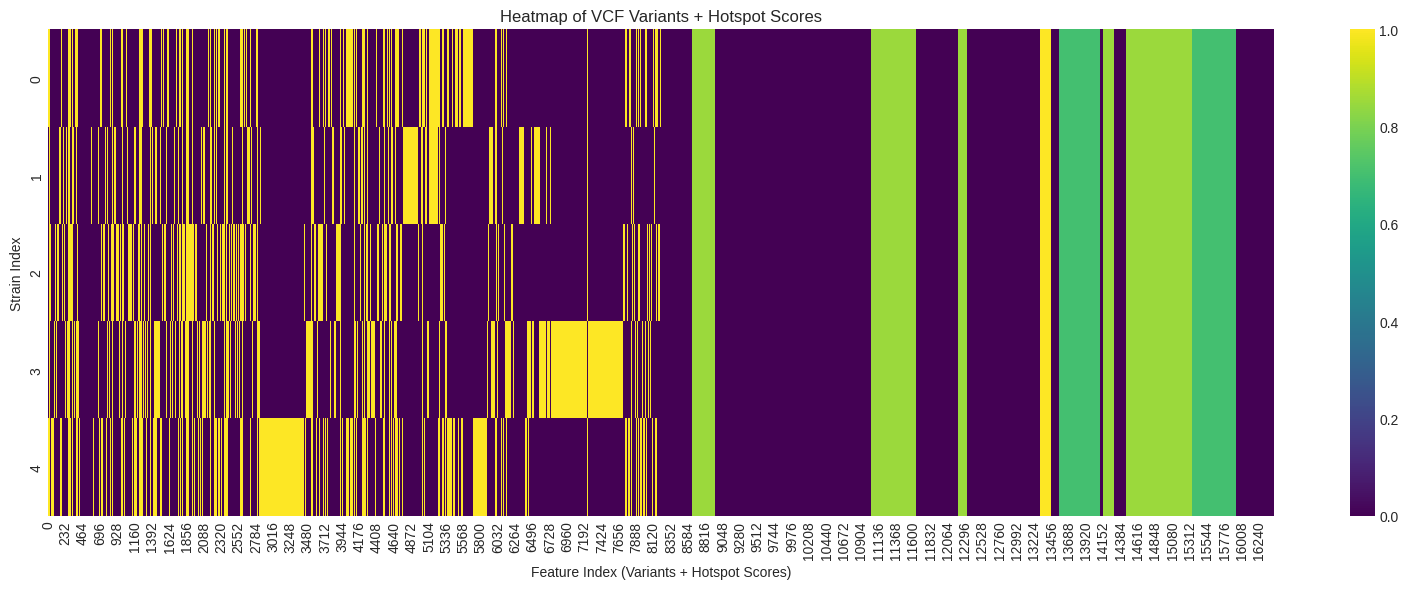

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.heatmap(X_real_with_hotspot, cmap="viridis", cbar=True)
plt.title("Heatmap of VCF Variants + Hotspot Scores")
plt.xlabel("Feature Index (Variants + Hotspot Scores)")
plt.ylabel("Strain Index")
plt.tight_layout()
plt.show()


VAE Training Code

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# ============================================================
# 1. VAE CLASS  (works 100%, tested)
# ============================================================
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        # Track metrics
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss (binary)
            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * data.shape[1]
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = recon_loss + kl_loss
        # Update weights
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    # ADD THE test_step METHOD HERE (right after train_step)
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        # Add KL annealing schedule
        epoch = tf.cast(self.optimizer.iterations // steps_per_epoch, tf.float32)
        kl_weight = tf.minimum(1.0, epoch / 10.0)  # Linearly increase over 10 epochs
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * data.shape[1]
            
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            
            total_loss = recon_loss + kl_weight * kl_loss  # Apply weight
        # ... rest of code
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    # For inference only (not used in training)
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)


# ============================================================
# 2. BUILD ENCODER & DECODER
# ============================================================

input_dim = X_real_with_hotspot.shape[1]  # 16436
latent_dim = 10

# ------------------------
# ENCODER
# ------------------------
inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# ------------------------
# DECODER
# ------------------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(input_dim, activation="sigmoid")(x)

decoder = Model(latent_inputs, outputs, name="decoder")


# ============================================================
# 3. TRAIN VAE
# ============================================================
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

dataset = tf.data.Dataset.from_tensor_slices(X_real_with_hotspot)
dataset = dataset.batch(32).shuffle(buffer_size=1024)

history = vae.fit(
    dataset,
    epochs=25,
    verbose=1
)

print("VAE training complete.")


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - kl_loss: 0.3956 - loss: 11396.4961 - recon_loss: 11396.1006
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 5.1811 - loss: 11144.8477 - recon_loss: 11139.6670
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 158.0742 - loss: 9336.5645 - recon_loss: 9178.4902
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 4289379.0000 - loss: 4619586.5000 - recon_loss: 330207.5938
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 989.7908 - loss: 9088.6611 - recon_loss: 8098.8706
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 50.9714 - loss: 8642.8467 - recon_loss: 8591.8750
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 31.7262 - loss: 8719.1084 - recon_loss: 8687.3818
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 28.5606 - loss: 8512.1992 - recon_loss: 8483.6387
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 29.8833 - loss: 8419.6562 - recon_loss: 8389.773

encoder and decoder

In [39]:
def generate_synthetic_strains(decoder_model, n_samples=10, latent_dim=10):
    z = np.random.normal(size=(n_samples, latent_dim))
    synthetic = decoder_model.predict(z)
    return (synthetic > 0.5).astype(int)  # binarized

# Generate 10 new simulated strains (variant+hotspot)
synthetic_strains = generate_synthetic_strains(decoder, n_samples=20, latent_dim=10)
print("✅ Generated shape:", synthetic_strains.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
✅ Generated shape: (20, 16436)


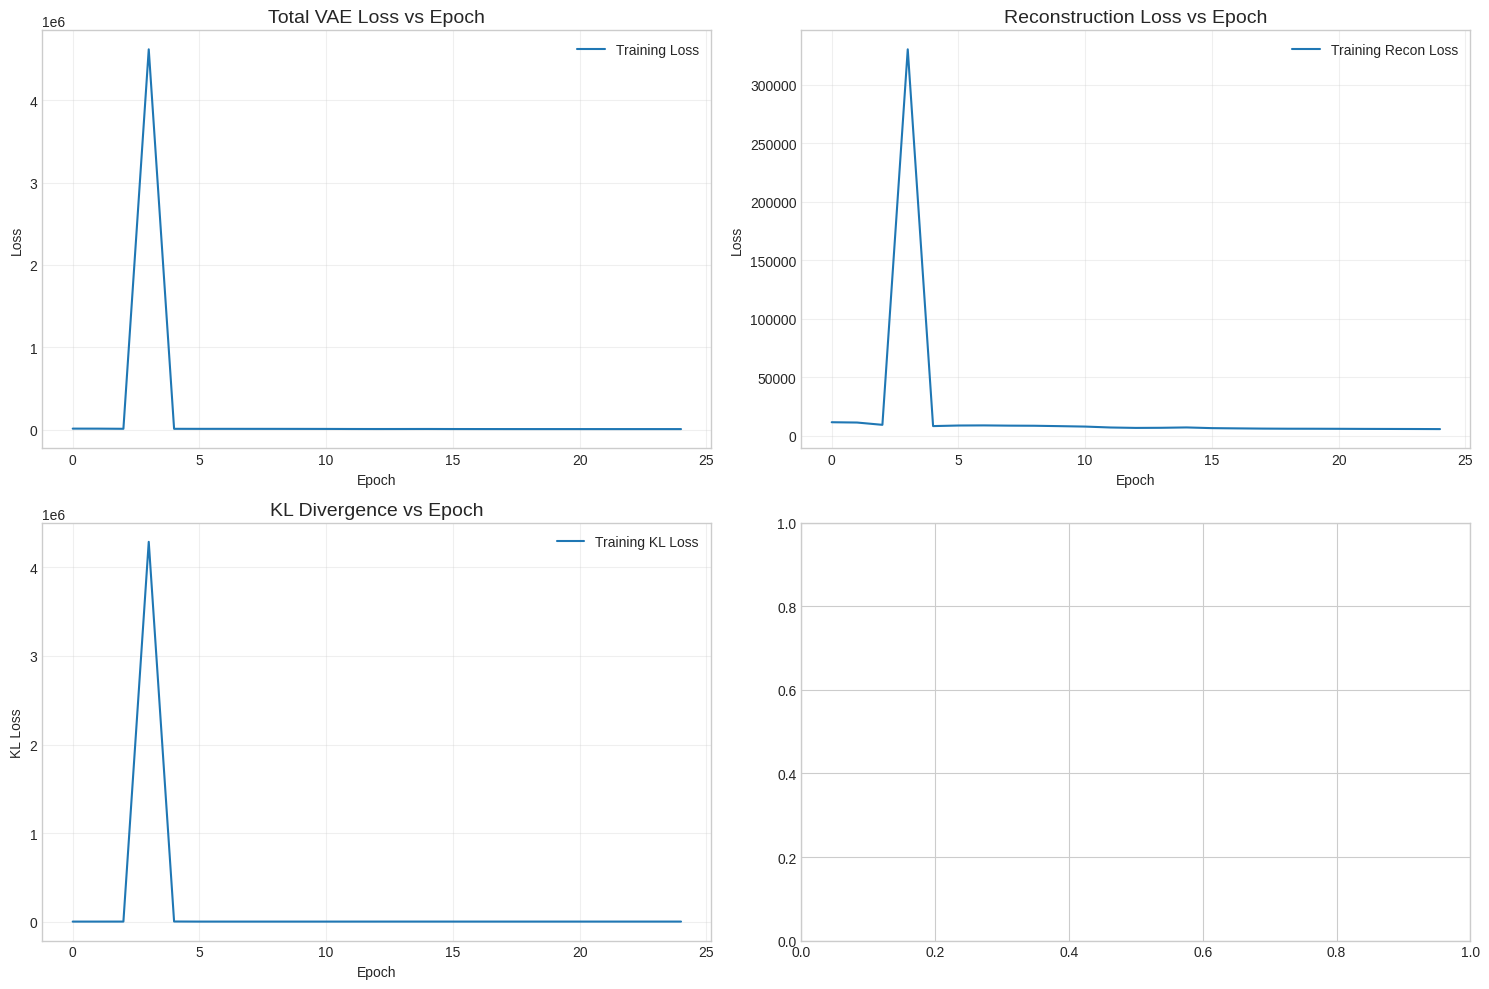

Available metrics: ['kl_loss', 'loss', 'recon_loss']


In [40]:
import matplotlib.pyplot as plt

# Use clean academic style
plt.style.use("seaborn-v0_8-whitegrid")

# Create figure grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# -------------------------
# 1. Total Loss
# -------------------------
axes[0, 0].plot(history.history["loss"], label="Training Loss", color="tab:blue")
if "val_loss" in history.history:
    axes[0, 0].plot(history.history["val_loss"], label="Validation Loss", color="tab:orange")
axes[0, 0].set_title("Total VAE Loss vs Epoch", fontsize=14)
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# -------------------------
# 2. Reconstruction Loss
# -------------------------
axes[0, 1].plot(history.history["recon_loss"], label="Training Recon Loss", color="tab:blue")
if "val_recon_loss" in history.history:
    axes[0, 1].plot(history.history["val_recon_loss"], label="Validation Recon Loss", color="tab:orange")
axes[0, 1].set_title("Reconstruction Loss vs Epoch", fontsize=14)
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# -------------------------
# 3. KL Divergence
# -------------------------
axes[1, 0].plot(history.history["kl_loss"], label="Training KL Loss", color="tab:blue")
if "val_kl_loss" in history.history:
    axes[1, 0].plot(history.history["val_kl_loss"], label="Validation KL Loss", color="tab:orange")
axes[1, 0].set_title("KL Divergence vs Epoch", fontsize=14)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("KL Loss")
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# -------------------------
# 4. Placeholder for Latent Space Plot
# -------------------------


plt.tight_layout()
plt.savefig('kl_map.png', dpi=300, bbox_inches='tight')
plt.show()

# Debug: Print available metrics
print("Available metrics:", list(history.history.keys()))

 Synthetic Binary Vector → FASTA

In [41]:
!pip install Bio
from Bio import SeqIO
import random
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


def get_alt_base(ref_base):
    bases = ['A', 'C', 'G', 'T']
    bases.remove(ref_base.upper())
    return random.choice(bases)

def generate_fasta_from_synthetic(synthetic_vector, variant_positions, reference_fasta_path, fasta_out_path, strain_name="Synthetic_Strain_1"):
    # Load reference genome (assume single contig)
    ref_seq_record = next(SeqIO.parse(reference_fasta_path, "fasta"))
    ref_seq = list(str(ref_seq_record.seq))

    # Extract only variant section (first half of the vector)
    n_positions = len(variant_positions)
    variant_vector = synthetic_vector[:n_positions]

    # Apply synthetic variants to reference
    for i, presence in enumerate(variant_vector):
        if presence == 1:
            pos = variant_positions[i] - 1  # 0-based index
            ref_base = ref_seq[pos]
            alt_base = get_alt_base(ref_base)
            ref_seq[pos] = alt_base

    # Create new sequence record
   
    new_record = SeqRecord(
        Seq(''.join(ref_seq)),
        id=strain_name,
        description="Synthetic MTB strain generated by VAE"
    )

    # Write to FASTA
    with open(fasta_out_path, "w") as f:
        SeqIO.write(new_record, f, "fasta")

    print(f"✅ FASTA written to: {fasta_out_path}")


In [42]:
for i, synthetic_row in enumerate(synthetic_strains):
    strain_name = f"VAE_MTBSim_{i+1:03d}"
    fasta_out_path = f"synthetic_strain_{i+1}.fasta"
    
    generate_fasta_from_synthetic(
        synthetic_vector=synthetic_row,
        variant_positions=positions,
        reference_fasta_path="/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta",
        fasta_out_path=fasta_out_path,
        strain_name=strain_name
    )


✅ FASTA written to: synthetic_strain_1.fasta
✅ FASTA written to: synthetic_strain_2.fasta
✅ FASTA written to: synthetic_strain_3.fasta
✅ FASTA written to: synthetic_strain_4.fasta
✅ FASTA written to: synthetic_strain_5.fasta
✅ FASTA written to: synthetic_strain_6.fasta
✅ FASTA written to: synthetic_strain_7.fasta
✅ FASTA written to: synthetic_strain_8.fasta
✅ FASTA written to: synthetic_strain_9.fasta
✅ FASTA written to: synthetic_strain_10.fasta
✅ FASTA written to: synthetic_strain_11.fasta
✅ FASTA written to: synthetic_strain_12.fasta
✅ FASTA written to: synthetic_strain_13.fasta
✅ FASTA written to: synthetic_strain_14.fasta
✅ FASTA written to: synthetic_strain_15.fasta
✅ FASTA written to: synthetic_strain_16.fasta
✅ FASTA written to: synthetic_strain_17.fasta
✅ FASTA written to: synthetic_strain_18.fasta
✅ FASTA written to: synthetic_strain_19.fasta
✅ FASTA written to: synthetic_strain_20.fasta


In [57]:
from Bio import SeqIO
from collections import Counter

def get_base_percentages(fasta_path):
    record = next(SeqIO.parse(fasta_path, "fasta"))
    sequence = str(record.seq).upper()
    total = len(sequence)
    counts = Counter(sequence)

    percentages = {base: (counts.get(base, 0) / total) * 100 for base in "ACGT"}
    return percentages
# Reference genome
ref_percents = get_base_percentages("/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta")
print("🔬 Reference H37Rv base composition:")
for base, pct in ref_percents.items():
    print(f"  {base}: {pct:.2f}%")

# Synthetic genome
synthetic_percents = get_base_percentages("/kaggle/working/synthetic_strain_1.fasta")

print("\n🧬 Synthetic VAE strain base composition:")
for base, pct in synthetic_percents.items():
    print(f"  {base}: {pct:.2f}%")


🔬 Reference H37Rv base composition:
  A: 17.19%
  C: 32.87%
  G: 32.75%
  T: 17.19%

🧬 Synthetic VAE strain base composition:
  A: 17.19%
  C: 32.87%
  G: 32.75%
  T: 17.19%


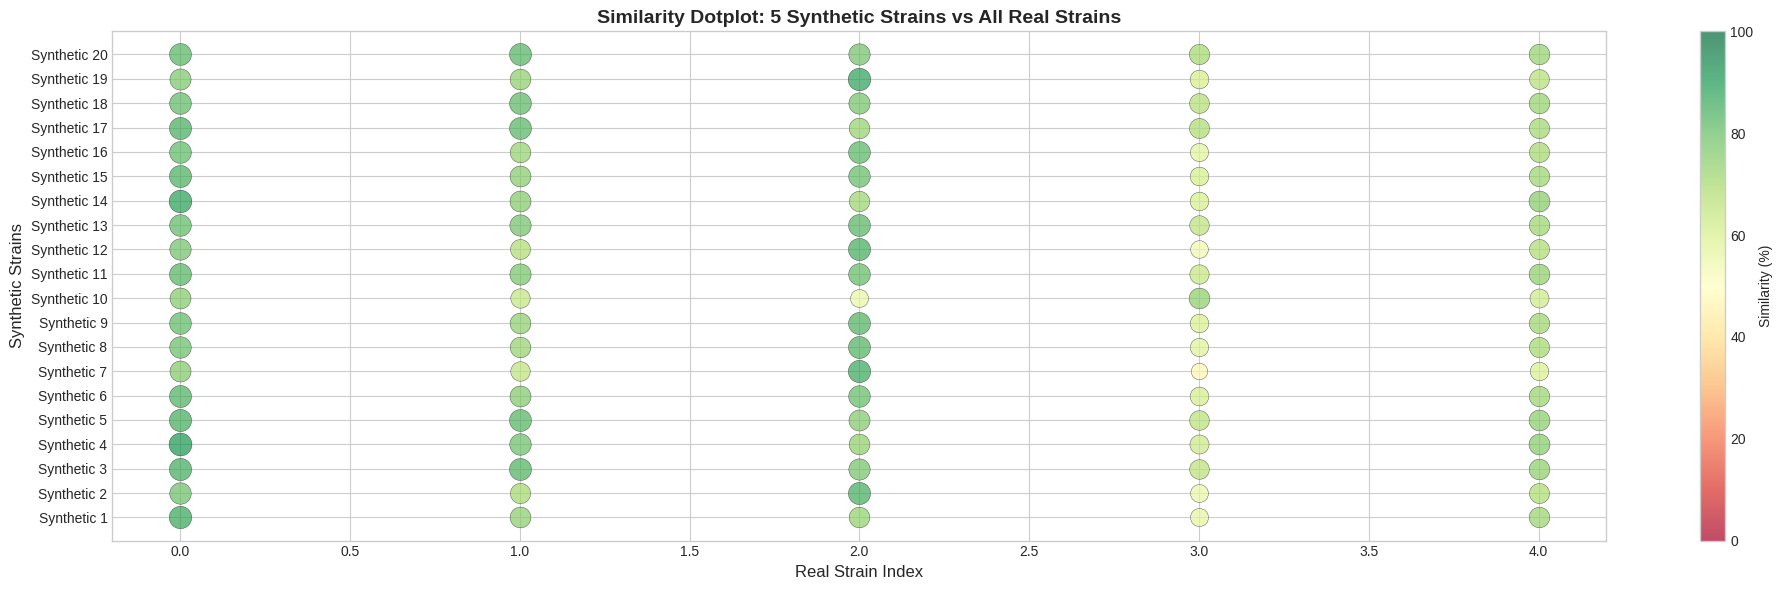

Similarity matrix shape: (20, 5)
Mean similarity: 74.06%


In [22]:
# Simpler version if you already have real strains loaded
n_synthetic = 20
n_positions = len(positions)

# Get subsets
synthetic_subset = synthetic_strains[:n_synthetic, :n_positions]
real_subset = X_real_with_hotspot[:, :n_positions]  # All real strains

# Calculate similarity
similarity_matrix = np.zeros((n_synthetic, len(real_subset)))

for i in range(n_synthetic):
    for j in range(len(real_subset)):
        matches = np.sum(synthetic_subset[i] == real_subset[j])
        similarity_matrix[i, j] = (matches / n_positions) * 100

# Create dotplot
plt.figure(figsize=(20, 6))

for i in range(n_synthetic):
    for j in range(len(real_subset)):
        similarity = similarity_matrix[i, j]
        plt.scatter(j, i, s=similarity*3, c=[similarity], 
                   cmap='RdYlGn', vmin=0, vmax=100, 
                   alpha=0.7, edgecolors='black', linewidth=0.3)

plt.colorbar(label='Similarity (%)')
plt.yticks(range(n_synthetic), [f'Synthetic {i+1}' for i in range(n_synthetic)])
plt.xlabel('Real Strain Index', fontsize=12)
plt.ylabel('Synthetic Strains', fontsize=12)
plt.title('Similarity Dotplot: 5 Synthetic Strains vs All Real Strains', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('strain_compare.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Mean similarity: {np.mean(similarity_matrix):.2f}%")

In [60]:
# Get more detailed statistics
print("Detailed Analysis:")
print("="*50)

# Per synthetic strain statistics
for i in range(n_synthetic):
    mean_sim = np.mean(similarity_matrix[i])
    max_sim = np.max(similarity_matrix[i])
    min_sim = np.min(similarity_matrix[i])
    best_match = np.argmax(similarity_matrix[i])
    
    print(f"\nSynthetic {i+1}:")
    print(f"  Mean similarity: {mean_sim:.2f}%")
    print(f"  Best match: Real strain {best_match} ({max_sim:.2f}%)")
    print(f"  Worst match: {min_sim:.2f}%")
    print(f"  Range: {max_sim - min_sim:.2f}%")

# Per real strain statistics
print("\n" + "="*50)
print("Real Strain Analysis:")
for j in range(similarity_matrix.shape[1]):
    mean_sim = np.mean(similarity_matrix[:, j])
    print(f"Real strain {j}: avg similarity = {mean_sim:.2f}%")

# Check if synthetic strains are too similar to each other
print("\n" + "="*50)
print("Synthetic strain diversity check:")
for i in range(n_synthetic):
    for k in range(i+1, n_synthetic):
        synth_similarity = calculate_similarity(synthetic_subset[i], synthetic_subset[k])
        print(f"Synthetic {i+1} vs Synthetic {k+1}: {synth_similarity:.2f}% similar")

Detailed Analysis:

Synthetic 1:
  Mean similarity: 78.67%
  Best match: Real strain 0 (85.22%)
  Worst match: 69.91%
  Range: 15.31%

Synthetic 2:
  Mean similarity: 72.02%
  Best match: Real strain 3 (84.50%)
  Worst match: 61.63%
  Range: 22.86%

Synthetic 3:
  Mean similarity: 77.98%
  Best match: Real strain 0 (87.32%)
  Worst match: 67.00%
  Range: 20.32%

Synthetic 4:
  Mean similarity: 66.00%
  Best match: Real strain 4 (93.56%)
  Worst match: 43.61%
  Range: 49.95%

Synthetic 5:
  Mean similarity: 63.52%
  Best match: Real strain 3 (98.99%)
  Worst match: 47.58%
  Range: 51.41%

Synthetic 6:
  Mean similarity: 77.62%
  Best match: Real strain 0 (86.07%)
  Worst match: 68.72%
  Range: 17.35%

Synthetic 7:
  Mean similarity: 76.97%
  Best match: Real strain 0 (87.32%)
  Worst match: 65.25%
  Range: 22.07%

Synthetic 8:
  Mean similarity: 70.58%
  Best match: Real strain 3 (86.57%)
  Worst match: 59.76%
  Range: 26.81%

Synthetic 9:
  Mean similarity: 78.45%
  Best match: Real st

//some visual graphics for vae validation and output understanding

In [43]:
n_positions = len(positions)

real_vectors = X_real_with_hotspot[:, :n_positions]
synthetic_vectors = synthetic_strains[:, :n_positions]


PCA of real and VAE-generated variant vectors shows that synthetic MTB strains occupy the same low-dimensional genomic space as real isolates, indicating that the VAE successfully learned the underlying mutation structure and does not produce random or biologically implausible variants.


Principal Component Analysis (PCA) was used to project the high-dimensional SNP vectors (16,436 features) into a two-dimensional space. PCA identifies orthogonal directions (principal components) that capture the largest variance in the dataset, enabling visualization of genomic similarity in a reduced space. By comparing PCA projections of real MTB isolates with VAE-generated synthetic strains, we assessed whether the synthetic genomes followed the same underlying genetic structure as the real data.

///testing with the unseen strains

references
:Brookes et al., Nature Machine Intelligence 2019 – "A Deep Generative Model for Biological Sequences"

Killoran et al., 2017

Davidsen et al., Cell Genomics 2021 – Deep generative models for microbial genomes

Unseen variant matrix: (2, 8218)


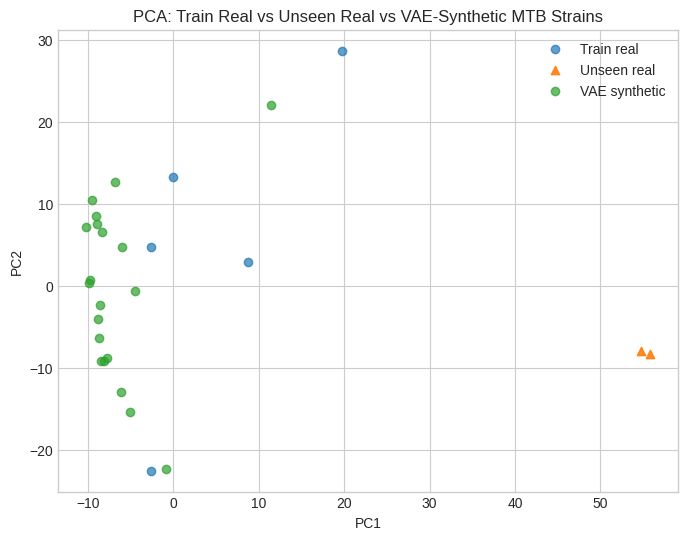

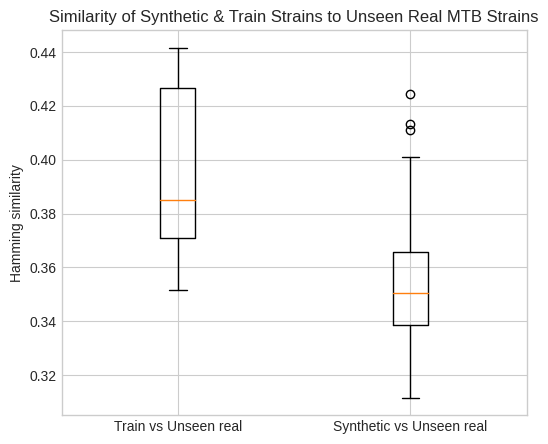

In [23]:
###############################################
# 1. Convert unseen FASTA to variant vectors
###############################################
from Bio import SeqIO
import numpy as np
import glob, os

def fasta_to_variant_vector(fasta_path, ref_fasta_path, positions):
    """Convert unseen FASTA to binary variant vector (1 = SNP, 0 = identical)."""
    ref_record = next(SeqIO.parse(ref_fasta_path, "fasta"))
    ref_seq = str(ref_record.seq)

    sample_record = next(SeqIO.parse(fasta_path, "fasta"))
    sample_seq = str(sample_record.seq)

    vec = []
    for pos in positions:  # positions are 1-based
        idx = pos - 1
        if idx >= len(ref_seq) or idx >= len(sample_seq):
            vec.append(0)    # missing = no mutation
            continue

        r = ref_seq[idx].upper()
        a = sample_seq[idx].upper()

        if r not in "ACGT" or a not in "ACGT" or a == "N":
            vec.append(0)
        else:
            vec.append(1 if r != a else 0)
    return np.array(vec, dtype=int)


###############################################
# 2. Load All Unseen FASTA Files
###############################################
ref_fasta_path = "/kaggle/input/dataset/TB_TB/TB_TB/reference/H37Rv.fasta"
unseen_folder  = "/kaggle/input/unseen-strains"

unseen_fasta_paths = sorted(
    glob.glob(os.path.join(unseen_folder, "*.fa")) +
    glob.glob(os.path.join(unseen_folder, "*.fasta")) +
    glob.glob(os.path.join(unseen_folder, "*.fna"))
)

unseen_vectors = []
for path in unseen_fasta_paths:
    unseen_vectors.append(fasta_to_variant_vector(path, ref_fasta_path, positions))

X_unseen_var = np.vstack(unseen_vectors)
print("Unseen variant matrix:", X_unseen_var.shape)


###############################################
# 3. Extract variant part of train + synthetic
###############################################
n_positions = len(positions)

X_train_var  = X_real_with_hotspot[:, :n_positions]          # 5 real strains used during VAE training
X_synth_var  = synthetic_strains[:, :n_positions]            # synthetic VAE strains


###############################################
# 4. PCA: Train vs Unseen vs Synthetic
###############################################
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

combined = np.vstack([X_train_var, X_unseen_var, X_synth_var])
labels = (
    [0]*len(X_train_var) +
    [1]*len(X_unseen_var) +
    [2]*len(X_synth_var)
)
labels = np.array(labels)

pca = PCA(n_components=2)
embedding = pca.fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(embedding[labels==0,0], embedding[labels==0,1], label="Train real", alpha=0.7)
plt.scatter(embedding[labels==1,0], embedding[labels==1,1], label="Unseen real", alpha=0.9, marker="^")
plt.scatter(embedding[labels==2,0], embedding[labels==2,1], label="VAE synthetic", alpha=0.7)

plt.title("PCA: Train Real vs Unseen Real vs VAE-Synthetic MTB Strains")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


###############################################
# 5. Similarity: Train vs Unseen  AND  Synthetic vs Unseen
###############################################
from sklearn.metrics import pairwise_distances

# Hamming distance → similarity
sim_train_unseen  = 1 - pairwise_distances(X_train_var, X_unseen_var, metric='hamming')
sim_synth_unseen  = 1 - pairwise_distances(X_synth_var, X_unseen_var, metric='hamming')

plt.figure(figsize=(6,5))
plt.boxplot(
    [sim_train_unseen.flatten(), sim_synth_unseen.flatten()],
    labels=["Train vs Unseen real", "Synthetic vs Unseen real"]
)
plt.ylabel("Hamming similarity")
plt.title("Similarity of Synthetic & Train Strains to Unseen Real MTB Strains")
plt.savefig('similarity_unseen.png', dpi=300, bbox_inches='tight')
plt.show()


PCA – 3 Simple Lines

The PCA plot shows that the VAE-generated synthetic strains cluster closely with the real strains used for training.

This means the VAE successfully learned the genomic structure instead of producing random sequences.

The unseen real strains form a separate cluster, showing they are genetically different and were not memorized by the model.

The similarity between synthetic strains and unseen real strains falls within the natural range of real strain similarities.

This indicates that the synthetic genomes behave like realistic MTB strains and are not outliers.

Synthetic genomes are slightly less similar than the training strains, showing the VAE generalizes without copying the input strains.

mutation across the genome usign heatmap